# **GPT로 데이터 합성해보기**
> **해당 데이터를 학습 데이터 활용하여 오히려 점수가 떨어진 점 참고바랍니다.**  
> 아래 코드는 **Upstage AI Lab**의 일상 대화 요약 대회에서 **GPT API를 활용**해 데이터를 합성했던 코드입니다.   
> 대회 당시 **GPT3.5**로 데이터를 합성하였으며 GPT에게 원본 학습 데이터로부터 5개의 대화문 및 요약문을 **5 shot**으로 보여준 뒤 대화문을 하나 샘플링하여 거기에 대한 새로운 요약문을 생성하도록 하였습니다.  

In [16]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import re
import glob
import random

import pandas as pd
from konlpy.tag import Mecab
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

## 1 데이터 불러오기 및 전처리

In [17]:
# 데이터 EDA용 코드
def print_data(df, start=0, end=None, count=5, print_random=False, mode='loc'):
    if print_random:
        samples_idx = df.sample(count).index
    else:
        if mode == 'loc':
            if end==None:
                samples_idx = df.loc[start:start+count].index
            else:
                samples_idx = df.loc[start:end].index
        elif mode == 'iloc':
            if end==None:
                samples_idx = df.iloc[start:start+count].index
            else:
                samples_idx = df.iloc[start:end].index
                
    
    print(samples_idx)
    for i in samples_idx:
        fname = df.loc[i, 'fname'] if 'fname' in df.columns else None
        dialogue = df.loc[i, 'dialogue'] if 'dialogue' in df.columns else None
        summary = df.loc[i, 'summary'] if 'summary' in df.columns else None
        pred = df.loc[i, 'pred'] if 'pred' in df.columns else None
        
        print("="*50)
        print(f"[{fname}]")
        if dialogue:
            print("[Dialogue]")
            print(dialogue)
        if summary:
            print("[Summary]")
            print(summary)
        if pred:
            print("[Prediction]")
            print(pred)
        
        if 'rouge_1' in df.columns:
            rouge_1 = df.loc[i, 'rouge_1']
            rouge_2 = df.loc[i, 'rouge_2']
            rouge_L = df.loc[i, 'rouge_L']
            print(f"rouge_1: {rouge_1:.4f}, rouge_2: {rouge_2:.4f}, rouge_L: {rouge_L:.4f}")

### 1.1 Data Load

In [18]:
train_df = pd.read_csv("../data/train.csv")

In [19]:
train_df

,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...","스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...",건강검진 받기
1,train_1,"#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...",파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...,백신
2,train_2,"#Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...","#Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...",열쇠 찾기
3,train_3,#Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...,#Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...,여자친구가 있다
4,train_4,"#Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...",말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...,댄스
...,...,...,...,...
12452,train_12455,#Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...,탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....,누군가를 태우다
12453,train_12456,#Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...,#Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...,컨퍼런스 센터
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.,차 렌트
12455,train_12458,#Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...,#Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...,실직


In [20]:
# 정규식 패턴에 해당하는 문자열을 replace하는 함수
def remove_extra_spc(x, pattern, replace_text):
    return re.sub(pattern, replace_text, x)

### 1.2 Data Process

In [22]:
# 데이터 전처리
train_df['dialogue'] = train_df['dialogue'].str.strip()
train_df['summary'] = train_df['summary'].str.strip()
train_df['dialogue_list'] = train_df['dialogue'].str.split("\n")

pattern = r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ0-9\s!#$%&*()+-=~‘’'\":.,/?…—–\x08><]"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, ""))

pattern = r"[>‘’]"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "\'"))

pattern = r"…"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "..."))

pattern = r"[—–\x08]"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, " "))

pattern = r"ㅇ"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "으"))

pattern = r"[ㄱ-ㅊㅌ-ㅎ]"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, ""))

pattern = r"##"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "#"))

pattern = r"#Person#"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "#Person1#"))

pattern = r"\r"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, ""))

train_df.loc[839, 'dialogue'] = train_df.loc[839, 'dialogue'].replace("사람1", "Person1#: ")

pattern = r"사람1#"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "#Person1#"))

pattern = r"^\"#Person"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "#Person"))

pattern = r"\"$"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, ""))

pattern = r"#Person 2#"
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: remove_extra_spc(x, pattern, "#Person2#"))

train_df.loc[7505, 'dialogue'] = train_df.loc[7505, 'dialogue'].replace("#Person2# 좋은 아침입니다.", "#Person2#: 좋은 아침입니다.")

train_df.loc[9547, 'dialogue'] = train_df.loc[9547, 'dialogue'].replace("#Person1: 성인을 대상으로", "#Person1#: 성인을 대상으로")
train_df.loc[9547, 'dialogue'] = train_df.loc[9547, 'dialogue'].replace("#Person2: 제 첫 두 소설은", "#Person2#: 제 첫 두 소설은")

train_df.loc[9548, 'dialogue'] = train_df.loc[9548, 'dialogue'].replace("#Person2: 분명히 그럴 거에요", "#Person2#: 분명히 그럴 거에요")
train_df.loc[9548, 'dialogue'] = train_df.loc[9548, 'dialogue'].replace("#Person1: 우리는 좋은 인상을", "#Person1#: 우리는 좋은 인상을")

train_df.loc[9750, 'dialogue'] = train_df.loc[9750, 'dialogue'].replace("Person1#: 이번 여름에 당신의", "#Person1#: 이번 여름에 당신의")

train_df.loc[9779, 'dialogue'] = train_df.loc[9779, 'dialogue'].replace("Person1#: 우리 오늘 운이 좋네.", "#Person1#: 우리 오늘 운이 좋네.")

# 각줄의 화자의 표시가 이상하게 돼 있는 데이터 수정
train_df.loc[969, 'dialogue'] = train_df.loc[969, 'dialogue'].replace("제프, 이 광고를 봐!", "#Person1#: 제프, 이 광고를 봐!")
train_df.loc[1213, 'dialogue'] = train_df.loc[1213, 'dialogue'].replace("#하지만 장기간의 무중력 상태,", "#Person1#: 하지만 장기간의 무중력 상태,")
train_df.loc[1236, 'dialogue'] = train_df.loc[1236, 'dialogue'].replace("#고객님, 크루즈 컨트롤에 대해", "#Person2#: 고객님, 크루즈 컨트롤에 대해")
train_df.loc[1250, 'dialogue'] = train_df.loc[1250, 'dialogue'].replace("#여기 있습니다. 스티븐스", "#Person1#: 여기 있습니다. 스티븐스")
train_df.loc[1266, 'dialogue'] = train_df.loc[1266, 'dialogue'].replace("#고객님, 저희는 고객이 화나거나", "#Person2#: 고객님, 저희는 고객이 화나거나")
train_df.loc[1278, 'dialogue'] = train_df.loc[1278, 'dialogue'].replace("#고객님, 죄송합니다만 계산대에서", "#Person2#: 고객님, 죄송합니다만 계산대에서")
train_df.loc[1281, 'dialogue'] = train_df.loc[1281, 'dialogue'].replace("#잠깐만요, 버전 7 요구 사항을", "#Person1#: 잠깐만요, 버전 7 요구 사항을")
train_df.loc[1283, 'dialogue'] = train_df.loc[1283, 'dialogue'].replace("#어디 보자. 네, 그런 방이 두 개", "#Person1#: 어디 보자. 네, 그런 방이 두 개")
train_df.loc[1301, 'dialogue'] = train_df.loc[1301, 'dialogue'].replace("#샐러드용 드레싱은 세 가지", "#Person1#: 샐러드용 드레싱은 세 가지")
train_df.loc[1302, 'dialogue'] = train_df.loc[1302, 'dialogue'].replace("#페리에와 짐 빔 세 병씩", "#Person1#: 페리에와 짐 빔 세 병씩")
train_df.loc[1306, 'dialogue'] = train_df.loc[1306, 'dialogue'].replace("#나 부엌에 있어", "#Person2#: 나 부엌에 있어")
train_df.loc[1322, 'dialogue'] = train_df.loc[1322, 'dialogue'].replace("#여기서 만나서 반갑습니다.", "#Person1#: 여기서 만나서 반갑습니다.")
train_df.loc[1424, 'dialogue'] = train_df.loc[1424, 'dialogue'].replace(" 방으로 가는 길은 어느", "#Person1#: 방으로 가는 길은 어느")
train_df.loc[1497, 'dialogue'] = train_df.loc[1497, 'dialogue'].replace(" 복사 한 장당 비용은", "#Person1#: 복사 한 장당 비용은")
train_df.loc[1547, 'dialogue'] = train_df.loc[1547, 'dialogue'].replace("#작은 걸로 주세요.", "#Person2#: 작은 걸로 주세요.")
train_df.loc[1609, 'dialogue'] = train_df.loc[1609, 'dialogue'].replace("#여기 있습니다.", "#Person2#: 여기 있습니다.")
train_df.loc[2240, 'dialogue'] = train_df.loc[2240, 'dialogue'].replace("사라가 왜 아직 안 왔지?", "#Person1#: 사라가 왜 아직 안 왔지?")
train_df.loc[5812, 'dialogue'] = train_df.loc[5812, 'dialogue'].replace("공장에서의 모든 직원들이 거리에서", "#Person2#: 공장에서의 모든 직원들이 거리에서")
train_df.loc[5812, 'dialogue'] = train_df.loc[5812, 'dialogue'].replace("오늘 2천 명의 직원 중 한 명도", "#Person1#: 오늘 2천 명의 직원 중 한 명도")

# 두번 연속해서 말하는 데이터 수정
train_df.loc[345, 'dialogue'] = train_df.loc[345, 'dialogue'].replace("#Person1#: 아니요. 입원할 필요는 없습니다.", "#Person2#: 아니요. 입원할 필요는 없습니다.")
train_df.loc[484, 'dialogue'] = train_df.loc[484, 'dialogue'].replace("#Person1#: 인상적이네. 우리는 좋은 관계야.", "#Person1#: 인상적이네. \n#Person2#: 우리는 좋은 관계야.")
train_df.drop(756, inplace=True)
train_df.loc[872, 'dialogue'] = train_df.loc[872, 'dialogue'].replace("#Person1#: 중국은행에서 개설한", "#Person2#: 중국은행에서 개설한")
train_df.drop(925, inplace=True)
train_df.drop(982, inplace=True)
train_df.loc[1033, 'dialogue'] = train_df.loc[1033, 'dialogue'].replace("#Person2#: 메리가 좋아할 만한 것에 대해 생각해봐야 해. 메리의 취미가 뭐야?", "#Person2#: 메리가 좋아할 만한 것에 대해 생각해봐야 해.\n#Person1#: 메리의 취미가 뭐야?")
train_df.loc[1220, 'dialogue'] = train_df.loc[1220, 'dialogue'].replace("#Person2#: 음, 치아에 충치가 있고, 크라운도", "#Person1#: 음, 치아에 충치가 있고, 크라운도")
train_df.drop(1294, inplace=True)
train_df.loc[1419, 'dialogue'] = train_df.loc[1419, 'dialogue'].replace("때문이에요.\n#Person1#: 어떠세요?", "때문이에요. 어떠세요?")
train_df.loc[1440, 'dialogue'] = train_df.loc[1440, 'dialogue'].replace("네. 방을 예약하고 싶습니다. 언제 예약하시겠습니까? ", "네. 방을 예약하고 싶습니다.\n#Person1#: 언제 예약하시겠습니까?")
train_df.loc[1475, 'dialogue'] = train_df.loc[1475, 'dialogue'].replace("아르바이트가 필요해요.\n#Person2#: 그거 좋겠네요.\n", "아르바이트가 필요해요.\n")
train_df.drop(1791, inplace=True)
train_df.loc[1899, 'dialogue'] = train_df.loc[1899, 'dialogue'].replace("#Person1#: 한번 봐볼까. 이게 뭐야?", "#Person2#: 한번 봐볼까. 이게 뭐야?")
train_df.loc[2240, 'dialogue'] = train_df.loc[2240, 'dialogue'].replace("다른 셔츠들과 함께 옷장에 있어. \n#Person1#: 사라가 왜 아직 안 왔지?", "다른 셔츠들과 함께 옷장에 있어. 사라가 왜 아직 안 왔지?")
train_df.loc[3628, 'dialogue'] = train_df.loc[3628, 'dialogue'].replace("된 게 아니라고요. 당신의 전면 범퍼도 마찬가지로 망가져 있잖아요.", "된 게 아니라고요.\n#Person1#: 당신의 전면 범퍼도 마찬가지로 망가져 있잖아요.")
train_df.loc[5441, 'dialogue'] = train_df.loc[5441, 'dialogue'].replace("#Person1#: 문제 없어!\n#Person1#: 안녕, 내가 왔어!", "#Person1#: 문제 없어! 안녕, 내가 왔어!")
train_df.loc[6759, 'dialogue'] = train_df.loc[6759, 'dialogue'].replace("제 엄마는 코를 긁고요. \n#Person2#: 아, 눈-분명해요.", "제 엄마는 코를 긁고요. 아, 눈-분명해요.")
train_df.drop(6799, inplace=True)
train_df.loc[8645, 'dialogue'] = train_df.loc[8645, 'dialogue'].replace("#Person2#: 저는 서프라이즈 다운타운이라는", "#Person1#: 저는 서프라이즈 다운타운이라는")

sample_list = train_df.loc[9898, 'dialogue_list']
for i in range(1, len(sample_list)):
    if i % 2 != 0:
        sample_list[i] = sample_list[i].replace("#Person1#:", "#Person2#:")
    else:
        sample_list[i] = sample_list[i].replace("#Person2#:", "#Person1#:")

train_df.loc[9898, 'dialogue'] = "\n".join(sample_list)

train_df.loc[11578, 'dialogue'] = train_df.loc[11578, 'dialogue'].replace("그런데 쉽지 않았어요.\n#Person1#: 여기 보시겠어요?", "그런데 쉽지 않았어요. 여기 보시겠어요?")
train_df.reset_index(drop=True, inplace=True)

## 2 GPT 

In [23]:
# API 키 불러오기
load_dotenv()
API_KEY = os.environ.get("OPENAI_API_KEY")

In [25]:
# gpt-4-0125-preview
# gpt-3.5-turbo

### 2.1 API 호출함수 정의 및 Prompt engineering

In [198]:
def get_gpt_response(examples, question):
    client = OpenAI(api_key=API_KEY)

    # GTP API 호출
    response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "너는 대화문을 읽고 요약하는 전문언어학자야. 너의 역할은 2명 이상의 사람들이 대화하는 대화문을 읽고 그 내용을 요약하는 게 너의 임무야. 그리고 요약할때 최대한 짧게 요약해줘."},
        {"role": "assistant", "content": "알겠어요. 대화문을 읽고 짧게 요약할게요. 요청해주세요."},
        {"role": "user", "content": examples}, # few shot 설정
        {"role": "assistant", "content": "알겠어요. 대화문을 보고 요약할게요. 계속 진행해주세요."},
        {"role": "user", "content": question} # 실제 질의
    ]
    )
    
    # 결과값 반환
    gpt_pred = response.choices[0].message.content
    
    return gpt_pred

### 2.2 API 호출 자동화 및 저장

In [233]:
count = 0 # 테스트용 변수
bundle_num = 10 # 파일을 저장할 단위(중간에 오류가 나거나 커널이 종료되면 비용만 나가고 데이터가 소멸될 것 대비)
data_point = 4647 # 시작점(오류 등의 이유로 중지될 경우 다시 시작할 위치)
gpt_train = pd.DataFrame(columns=['fname', 'dialogue', 'summary'])

train_ex = train_df.copy() # 예제로 쓰일 데이터를 추출한 예제 데이터셋

for i in range(data_point, len(train_df)):
    fname = train_df.loc[i, 'fname']
    q_dialogue = train_df.loc[i, 'dialogue'] # 최종적으로 질문으로 줄 대화문
    q_summary = train_df.loc[i, 'summary']
    
    gpt_question = f"[Dialogue]\n{q_dialogue}" # 질문 구성
    
    # 예제 데이터셋에서 질문할 데이터를 drop(질문할 데이터가 예제에 포함되지 않기 위함)
    temp_df = train_ex.drop(i) if i in train_ex.index else train_ex
    
    # 예제 데이터셋에서 예제로 넣어줄 데이터 5개 샘플링 및 제거(다양한 샘플을 활용하기 위해)
    examples = temp_df.sample(5)
    train_ex.drop(examples.index, inplace=True)
    
    # 예제 구성(5 shot)
    example1 = "예시1\n[Dialogue]\n" + examples.iloc[0, 1] + "\n[Summary]\n" + examples.iloc[0, 2] + "\n\n"
    example2 = "예시2\n[Dialogue]\n" + examples.iloc[1, 1] + "\n[Summary]\n" + examples.iloc[1, 2] + "\n\n"
    example3 = "예시3\n[Dialogue]\n" + examples.iloc[2, 1] + "\n[Summary]\n" + examples.iloc[2, 2] + "\n\n"
    example4 = "예시4\n[Dialogue]\n" + examples.iloc[3, 1] + "\n[Summary]\n" + examples.iloc[3, 2] + "\n\n"
    example5 = "예시5\n[Dialogue]\n" + examples.iloc[4, 1] + "\n[Summary]\n" + examples.iloc[4, 2]
    examples_str = example1 + example2+ example3 + example4 + example5
    
    # 최종 예제 구성
    gpt_examples = f"아래는 너가 앞으로 수행해야하는 임무의 예시 5개야. [Dialogue]의 대화 내용을 읽고 [Summary]와 같은 요약문을 작성하면 돼. 예시를 보고난 후 내가 준 [Dialogue]에 대해서 요약을 진행해줘.\n\n{examples_str}"
    
    # GPT API 호출 및 결과반환
    gpt_summary = get_gpt_response(gpt_examples, gpt_question)
    gpt_summary = re.sub(r"^\[Summary\]\n", "", gpt_summary)
    
    data ={
        "fname": fname,
        "dialogue": q_dialogue,
        "summary": gpt_summary
    }
    gpt_train.loc[i] = data
    
    # 예제 데이터셋이 5개 이하인 경우 초기화
    if len(temp_df) < 5:
        train_ex = train_df.copy()
        
    # bundle_num 단위마다 csv 파일로 저장
    if i % bundle_num == 0:
        gpt_train.to_csv(f"../data/gpt_data/gpt_train{i-bundle_num}_{i}.csv", index=False)
        print(f"gpt_train{i-bundle_num}_{i}.csv")
        gpt_train = pd.DataFrame(columns=['fname', 'dialogue', 'summary'])
        
        folder_path = '../data/gpt_data/'
        # if count > 2:
        #     break
        
        count += 1

### 2.3 결과 확인 및 실제 요약문과 비교

In [234]:
# few shot 확인
print(gpt_examples)

아래는 너가 앞으로 수행해야하는 임무의 예시 5개야. [Dialogue]의 대화 내용을 읽고 [Summary]와 같은 요약문을 작성하면 돼. 예시를 보고난 후 내가 준 [Dialogue]에 대해서 요약을 진행해줘.

예시1
[Dialogue]
#Person1#: 톰, 이번 주말에 뭐 할 거야?
#Person2#: 아직 모르겠어. 보통 집에서 티비를 보거나 때때로 컴퓨터 게임을 하지. 좋은 아이디어 있어?
#Person1#: 영화관에 가보자. 오랫동안 영화를 보지 않았어. 아이스 에이지 4가 정말 인기가 많다고 들었어. 같이 가서 보자.
#Person2#: 음, 나는 카툰에 별로 관심이 없어. 체육관에서 테니스를 치는 건 어때?
#Person1#: 좋아. 나는 스포츠를 좋아해. 언제 어디서 만날까?
#Person2#: 토요일 아침 9시에 체육관에서 만나자.
#Person1#: 좋아. 그때 봐.
#Person2#: 그때 봐.
[Summary]
톰과 #Person2#는 이번 주말 계획을 세우고 있다. 그들은 영화를 보는 것보다 테니스를 치는 것을 선호한다. 그들은 체육관에서 만날 예정이다.

예시2
[Dialogue]
#Person1#: 지금 운전 연습을 해볼래?
#Person2#: 문제 없어. 지금 바로 해도 돼.
#Person1#: 안전벨트 착용했니?
#Person2#: 응. 그럼 이제 뭘 해야 해?
#Person1#: 차에 시동 걸어.
#Person2#: 어느 방향으로 가야 해?
#Person1#: 왼쪽으로 가.
#Person2#: 얼마나 가야 해?
#Person1#: 멈춰야 할 때 알려줄게.
#Person2#: 미리 알려줘야 해.
#Person1#: 이제 돌아왔으니 주차 연습을 해볼까?
#Person2#: 재미있었어. 곧 다시 해보자.
[Summary]
#Person1#은 #Person2#에게 운전 연습을 시키고 지시를 내린다. #Person2#는 다시 하고 싶어한다.

예시3
[Dialogue]
#Person1#: 최근에 빌을 본 적 있어?
#Person2

In [235]:
# 질문 및 gpt 요약문, 실제 요약문 확인
print(gpt_question)
print()

print("[GPT Summary]")
print(gpt_summary)
print("[실제 Summary]")
print(q_summary)

[Dialogue]
#Person1#: 실례합니다, 스프링 가든에 가려고 하는데 여기서 먼가요?
#Person2#: 스프링 가든이요? 이쪽이 아닙니다. 그건 시내 중심가에 있어요.
#Person1#: 그런가요? 아, 이런. 누군가 이쪽이라고 말해줬어요.
#Person2#: 아니요, 아니요, 이쪽 아닙니다. 저쪽으로 가셔야 해요.
#Person1#: 네, 알겠습니다...저쪽으로.
#Person2#: 네, 그러다가 좌회전해요, 알겠죠?
#Person1#: 좌회전이요.
#Person2#: 네, 그리고 오른쪽, 첫 번째 거리로 가세요.
#Person1#: 오른쪽.
#Person2#: 그런 다음 직진으로 계속 걸어가세요.
#Person1#: 아, 모르겠어요. 정말 어렵게 들리네요. 음, 이 근처에서 택시를 탈 수 있을까요?
#Person2#: 그렇게 멀지 않아요. 그냥 거리 모퉁이까지 걸어가거나 다음 블록까지 가면 버스가 있어요.
#Person1#: 비가 오기 시작해요. 택시를 타야겠어요. 어쨌든 감사합니다.
#Person2#: 괜찮아요. 이쪽으로 가는 택시가 많아요.
#Person1#: 비에 다 젖었어요. 날이 정말 나쁘네요...

[GPT Summary]
#Person1#은 스프링 가든을 찾고있지만, 잘못된 방향으로 갔다. #Person2#는 올바른 경로와 택시를 타는 방법을 안내해주었다. #Person1#은 비에 젖은 채 스프링 가든을 찾으려 하고 있다.
[실제 Summary]
#Person2#가 #Person1#에게 스프링 가든 가는 길을 알려줍니다. #Person1#는 길이 복잡하다고 생각하고 날씨 때문에 택시를 타기로 합니다.


In [236]:
# GPT가 생성한 요약문과 실제 요약문의 유사도 비교
print("[GPT Summary]")
print(gpt_summary)
print("[실제 Summary]")
print(q_summary)
print()

# 형태소로 나누기
mecab = Mecab()
q_summary_morphs = " ".join(mecab.morphs(q_summary))
gpt_summary_morphs = " ".join(mecab.morphs(gpt_summary))

# Rouge Score 계산
rouge = Rouge()
result = rouge.get_scores(q_summary_morphs, gpt_summary_morphs, avg=True)
final_score =  (result['rouge-1']['f'] + result['rouge-2']['f'] + result['rouge-l']['f']) / 3

print("rouge-1: "+ str(result['rouge-1']))
print("rouge-2: "+ str(result['rouge-2']))
print("rouge-l: "+ str(result['rouge-l']))
print(final_score)

[GPT Summary]
#Person1#은 스프링 가든을 찾고있지만, 잘못된 방향으로 갔다. #Person2#는 올바른 경로와 택시를 타는 방법을 안내해주었다. #Person1#은 비에 젖은 채 스프링 가든을 찾으려 하고 있다.
[실제 Summary]
#Person2#가 #Person1#에게 스프링 가든 가는 길을 알려줍니다. #Person1#는 길이 복잡하다고 생각하고 날씨 때문에 택시를 타기로 합니다.

rouge-1: {'f': 0.4444444395918784, 'p': 0.5365853658536586, 'r': 0.3793103448275862}
rouge-2: {'f': 0.26804123226697846, 'p': 0.325, 'r': 0.22807017543859648}
rouge-l: {'f': 0.3636363587511479, 'p': 0.42857142857142855, 'r': 0.3157894736842105}
0.3587073435366683


### 2.4 합성한 데이터 합치기 및 유사도 비교

In [ ]:
# 폴더내 모든 csv의 Path 불러오기
def get_csv_files(folder_path):
    # 폴더 내 모든 파일 목록 가져오기
    files = glob.glob(os.path.join(folder_path, '*.csv'))
    return files

In [ ]:
# 파일삭제코드 주의!!!!!!!
# csv_list= get_csv_files("/root/nlp_project/data/gpt_data")
# for csv in csv_list:
#     os.remove(csv)

In [ ]:
# 모든 csv 파일 합치기
csv_list= get_csv_files("/root/nlp_project/data/gpt_data")
gpt_train = pd.DataFrame(columns=['fname', 'dialogue', 'summary'])
for csv in csv_list:
    temp_df = pd.read_csv(csv)
    gpt_train = pd.concat([gpt_train, temp_df], axis=0)

# 원본 데이터와 index 순서 맞춰주기
gpt_train['index'] = gpt_train['fname'].str.split("_").str[1].astype("int64")
gpt_train = gpt_train.sort_values(by='index').reset_index(drop=True)
del gpt_train['index']

# 저장
gpt_train.to_csv("/root/nlp_project/data/gpt_data/save/gpt_train.csv", index=False)

In [ ]:
gpt_train = pd.read_csv("/root/nlp_project/data/gpt_train.csv")

In [ ]:
# 전체 유사도 비교
temp = train_df.loc[gpt_train.index]

mecab = Mecab()
gpt_train['summary_morphs'] = gpt_train['summary'].apply(lambda x: " ".join(mecab.morphs(x)))
temp['summary_morphs'] = temp['summary'].apply(lambda x: " ".join(mecab.morphs(x)))

rouge = Rouge()
result = rouge.get_scores(gpt_train['summary_morphs'], temp['summary_morphs'], avg=True)
final_score =  (result['rouge-1']['f'] + result['rouge-2']['f'] + result['rouge-l']['f']) / 3

print("rouge-1: "+ str(result['rouge-1']))
print("rouge-2: "+ str(result['rouge-2']))
print("rouge-l: "+ str(result['rouge-l']))
print(final_score)

rouge-1: {'f': 0.4352751487055892, 'p': 0.37269382086388536, 'r': 0.5697062841917824}
rouge-2: {'f': 0.24608443308969202, 'p': 0.2095277096614036, 'r': 0.32568079093490554}
rouge-l: {'f': 0.3970430312735879, 'p': 0.34188429123187597, 'r': 0.49899552080814225}
0.35946753768962303


### 2.5 원본 데이터와 GPT 데이터의 길이 비교

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
gpt_train['summary_len'] = gpt_train['summary'].str.len()
train_df['summary_len'] = train_df['summary'].str.len()

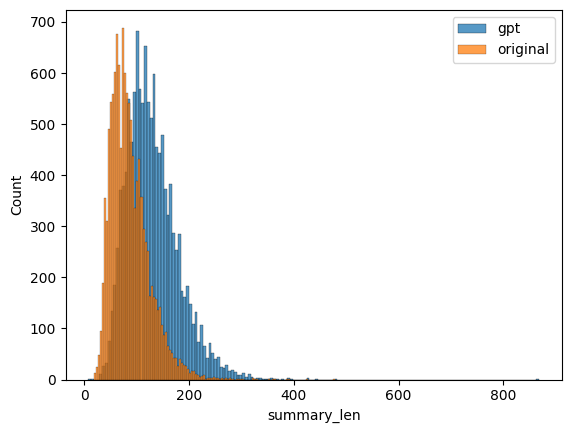

In [ ]:
sns.histplot(gpt_train, x="summary_len", label="gpt")
sns.histplot(train_df, x="summary_len", label="original")
plt.legend()
plt.show()